# TimePix MZI analysis written by Evan Klein

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import time
import pandas as pd
import pickle

from matplotlib.animation import FuncAnimation
from IPython.display import clear_output

# Initializing variables 

In [2]:
cent_csv = 'D:/MZI/ArLamp/ArLamp_Spectrometer_MZ_60m_W0028_F03-240410-161022_cent.csv' # File location of _cent.csv file
exposure_time = 20 # Time in seconds of each exposure in the motor moving code
motorMovementsPerExposure = 10 # Found within the motor moving code
total_time = 60 # Time in units of the time division you choose that the TimePix ran for
bin_period = 0.50/3 # Time period you want each bin to span over in units of the time division you choose
time_div_label = "min" # Time scale you want to use for plotting choose from: ms, sec, min, hrs, days

In [3]:
# Dictionary defining time scale you want to use for plotting
time_div_dict = {"ms" : 1/60, "sec" : 1, "min" : 60, "hrs" : 3600, "days" : 3600*24}
time_div_val = time_div_dict[time_div_label]

In [4]:
nbins = np.round(total_time / bin_period).astype(int)
print(f"{nbins} bins will be created over {total_time} {time_div_label}, meaning each bin has a period of {total_time/nbins} {time_div_label}")

360 bins will be created over 60 min, meaning each bin has a period of 0.16666666666666666 min


# Importing csv file

## Preview data

In [5]:
# Changing nrows affects how big an initial timechunk you collect (taking more rows takes longer but gives a better visual)
MZI_df_preview = pd.read_csv(cent_csv, nrows=10000000)
MZI_df_preview

,#Col,#Row,#ToA,#ToT[arb],#ToTtotal[arb],#Centroid,#cent_X,#cent_Y,#centStdev_X,#centStdev_Y,#centStdev_ToA,Unnamed: 11
0,145,0,160396882944,175,175,1,145.500000,0.500000,0.500000,0.500000,0,NaN
1,199,151,160397464576,950,1875,4,199.206667,151.793333,0.676231,0.676231,4139,NaN
2,145,0,160398654720,25,25,1,145.500000,0.500000,0.500000,0.500000,0,NaN
3,145,0,160399178496,125,125,1,145.500000,0.500000,0.500000,0.500000,0,NaN
4,167,82,160399244800,1900,3575,5,167.632867,82.709790,0.739616,0.644809,3911,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,91,211,4833735795968,700,875,2,91.500000,211.300000,0.500000,0.640312,3968,NaN
9999996,114,175,4833736068096,1225,2300,4,114.750000,175.543478,0.661438,0.682276,4254,NaN
9999997,88,169,4833736089088,950,2400,4,88.177083,169.916667,0.684574,0.702179,2059,NaN
9999998,170,6,4833736944128,650,2850,7,170.692982,6.350877,0.889778,0.842745,7908,NaN


## Creating global bins by getting first and last timestamps

In [6]:
start_time = int(MZI_df_preview.iloc[0]['#ToA'])
print(f"The beginning timestamp is {start_time}.")

The beginning timestamp is 160396882944.


In [7]:
with open(cent_csv, 'rb') as file:
    file.seek(0, 2)  # seek(0, 2) tells the cursor to go 0 spaces away from the end
    file_size = file.tell() # file.tell() gives current cursor position
    pos = file_size - 1
    string = ''
    for i in range(pos):
        char = file.read(1).decode('utf-8') # file.read(1) reads character at current cursor position
        if char == '\n':
            break # Stop collecting characters once first delimeter is found
        string += char
        pos -= 1
        file.seek(pos, 0) # Moves cursor back one
    string = string[::-1] # Reverses order to give correct string of last row   
    print(f"The last row in the csv is: {string}")
    
last_row_arr = string.split(',')
end_time = int(last_row_arr[2]) # ToA should be in the 3rd column
print(f"The final timestamp is {end_time}.")

The last row in the csv is: 162,148,592680544454912,325,700,3,162.964286,148.428571,0.706204,0.562429,4349,
The final timestamp is 592680544454912.


In [8]:
hist_bins = np.linspace(start_time, end_time, nbins+1) # nbins+1 is to ensure this is bin edges not just centers
hist_bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2.0 # List of centers of bins (Shorter than bin edges list by 1)

# Converting bin values from arbitrary timestamps to real time from start of experiment
bin_centers_rt = (np.array(hist_bin_centers) - start_time)/(end_time-start_time)*total_time

## Preview image for finding region limits

In [9]:
# Values used to draw box for finding rectangular region around the spot (x-coord, y-coord, x-size, y-size)
region_811_1_vals = [88, 88, 5, 5]
region_811_2_vals = [101, 87, 7, 7]

## Spectrum of Argon:
![Image of Argon spectra](ArSpectra.png)

## Defining all regions where different spots on detector are, change all values as needed

In [379]:
# In this order you need to define the region's:
# wavelength (nm), output number (left is 1, right is 2), x_start, x_extent, y_start, y_extent
# The display below has origin set to 'upper', so all coordinate inputs here get transposed later!!!

spot_df = []

# 852 nm
# spot_df.append([852.14, 1, 85, 10, 178, 5])
# spot_df.append([852.14, 2, 99, 10, 178, 5])

# 842 nm
spot_df.append([842.46, 1, 85, 10, 167, 5]) 
spot_df.append([842.46, 2, 99, 10, 167, 5])

# 826 nm
# spot_df.append([826.45, 1, 85, 10, 151, 5]) 
# spot_df.append([826.45, 2, 99, 10, 151, 5])

# 811 nm
spot_df.append([811.53, 1, 85, 10, 136, 5])
spot_df.append([811.53, 2, 99, 10, 136, 5])

# 801 nm
# spot_df.append([801.48, 1, 85, 10, 125, 5])
# spot_df.append([801.48, 2, 99, 10, 125, 5])

# 794 nm
spot_df.append([794.82, 1, 85, 10, 118, 5])
spot_df.append([794.82, 2, 99, 10, 118, 5])

### HERES THE GAP BETWEEN SPOTS ###

# 772 nm
spot_df.append([772.38, 1, 85, 10, 97, 5])
spot_df.append([772.38, 2, 99, 10, 97, 5])

# 763 nm
spot_df.append([763.51, 1, 85, 10, 88, 5])
spot_df.append([763.51, 2, 99, 10, 88, 5])

# # 750 nm
# spot_df.append([750.39, 1, 85, 10, 76, 5])
# spot_df.append([750.39, 2, 99, 10, 76, 5])

# # 738 nm
# spot_df.append([738.40, 1, 85, 10, 64, 5])
# spot_df.append([738.40, 2, 99, 10, 64, 5])

# # 727 nm
# spot_df.append([727.29, 1, 85, 10, 54, 5])
# spot_df.append([727.29, 2, 99, 10, 54, 5])

# # 706 nm
# spot_df.append([706.72, 1, 85, 10, 34, 5])
# spot_df.append([706.72, 2, 99, 10, 34, 5])

# # 696 nm
# spot_df.append([696.54, 1, 85, 10, 25, 5])
# spot_df.append([696.54, 2, 99, 10, 25, 5])


spot_df = pd.DataFrame(spot_df, columns=['wavelength(nm)', '#output', 'x_start', 'x_extent', 'y_start', 'y_extent'])

# Adding the x_end and y_end columns
spot_df.insert(3, 'x_end', spot_df['x_start'] + spot_df['x_extent'])
spot_df.insert(6, 'y_end', spot_df['y_start'] + spot_df['y_extent'])

# Adding the display_color column (currently using https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%2300E2A5-%23F0E442-%23D00101-%23D55E00-%23CC79A7-%2326156F-%2369AD5D-%239066ed-%236F0C29-%2366caf5)
display_colors = ['#000000', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e']#, '#D00101', '#D55E00', '#CC79A7', '#26156F', '#69AD5D', '#9066ed', '#6F0C29', '#66caf5']

# Duplicating colors above for assignment of both outputs
display_colors_duplicated = []
for color in display_colors:
    display_colors_duplicated.append(color)
    display_colors_duplicated.append(color)

spot_df['display_color'] = display_colors_duplicated

spot_df

,wavelength(nm),#output,x_start,x_end,x_extent,y_start,y_end,y_extent,display_color
0,842.46,1,85,95,10,167,172,5,#000000
1,842.46,2,99,109,10,167,172,5,#000000
2,811.53,1,85,95,10,136,141,5,#2ca02c
3,811.53,2,99,109,10,136,141,5,#2ca02c
4,794.82,1,85,95,10,118,123,5,#d62728
5,794.82,2,99,109,10,118,123,5,#d62728
6,772.38,1,85,95,10,97,102,5,#9467bd
7,772.38,2,99,109,10,97,102,5,#9467bd
8,763.51,1,85,95,10,88,93,5,#ff7f0e
9,763.51,2,99,109,10,88,93,5,#ff7f0e


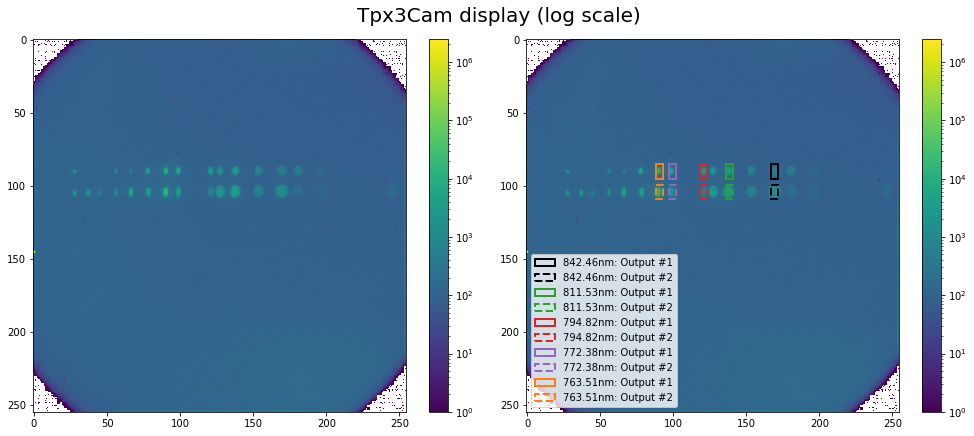

In [407]:
hist, xedges, yedges = np.histogram2d(MZI_df_preview['#Col'], MZI_df_preview['#Row'], bins=[255, 255])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Tpx3Cam display (log scale)", fontsize=20)

plt.subplot(121)
im1 = plt.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())
colorbar1 = plt.colorbar(im1)

plt.subplot(122)
im2 = plt.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())

for i, spot in spot_df.iterrows():
    label = f"{spot['wavelength(nm)']}nm: Output #{spot['#output']}"
    if spot['#output'] == 1:
        line_style = 'solid'
    elif spot['#output'] == 2:
        line_style = 'dashed'
    spot_patch = matplotlib.patches.Rectangle((spot['y_start'], spot['x_start']), spot['y_extent'], spot['x_extent'],
                    linewidth=2, edgecolor=spot['display_color'], facecolor='none', label=label, ls=line_style)
    ax2.add_patch(spot_patch)

colorbar2 = plt.colorbar(im2)
ax2.legend()

#plt.subplots_adjust(wspace=0.2)
fig.tight_layout()
plt.show()

### In the figure above spots are longer in wavelength the higher up they are, and the left and right columns are the two outputs (my convention is left is output 1, right is output 2)

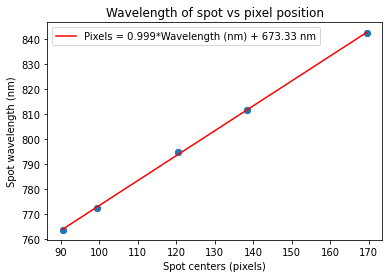

This spectrometer currently has a spectral resolution of 0.999 nm/pixel (1.001 pixel/nm)
This means with 255 total pixels a width of 254.81 nm can be fit on the detector, ranging from 673.33 nm - 928.14 nm.


In [201]:
spot_middle = (spot_df['y_start'] + spot_df['y_end']) / 2
plt.scatter(spot_middle, spot_df['wavelength(nm)'])

# Linear fitting
coefficients = np.polyfit(spot_middle, spot_df['wavelength(nm)'], 1)
m, b = coefficients
wavelength_linspace = np.linspace(min(spot_middle), max(spot_middle), 100)
pixel_vals = m * wavelength_linspace + b

plt.plot(wavelength_linspace, pixel_vals, color='red', label=f'Pixels = {m:.3f}*Wavelength (nm) + {b:.2f} nm')

plt.xlabel("Spot centers (pixels)")
plt.ylabel("Spot wavelength (nm)")
plt.title("Wavelength of spot vs pixel position")
plt.legend()
plt.show()

wavelength_per_pixel = m
print(f"This spectrometer currently has a spectral resolution of {wavelength_per_pixel:.3f} nm/pixel ({wavelength_per_pixel**-1:.3f} pixel/nm)")
print(f"This means with 255 total pixels a width of {wavelength_per_pixel*255:.2f} nm can be fit on the detector, ranging from {b:.2f} nm - {b+wavelength_per_pixel*255:.2f} nm.")

# Binning timestamps within regions into separate histograms (similar to data reading of SPADs)

### The code below should only need to be run one time when data is first collected, .pkl files should be created after to store all histograms to avoid this time consuming process again

In [202]:
chunk_size = 10000000 # Defines how many entries of the csv will be read into memory at one time

# Adding column named hist_vals filled with np.zeros(nbins)
hist_vals = [np.zeros(nbins) for _ in range(spot_df.shape[0])]

with pd.read_csv(cent_csv, usecols=['#Col', '#Row', '#ToA'], chunksize=chunk_size) as reader:
    for chunk in reader:
        # Extract timestamps within specified regions defined above within the current chunk of the file
        for i, spot in spot_df.iterrows():
            spot_timestamps = chunk[
                (spot['x_start'] <= chunk['#Row']) & (chunk['#Row'] <= spot['x_end']) &
                (spot['y_start'] <= chunk['#Col']) & (chunk['#Col'] <= spot['y_end'])]['#ToA']
            
            # Aggregating all timestamps for spot within corresponding hist_vals list
            hist_vals[i] += np.histogram(spot_timestamps, bins=hist_bins)[0]
            
        # Creating display for where you are in file
        last_timestamp = chunk.iloc[-1]
        rt = last_timestamp['#ToA'] * total_time / (end_time - start_time)
        
        clear_output(wait=True)
        print(f"Current position in csv: {rt} {time_div_label}")
        
spot_df['hist_vals'] = hist_vals
spot_df

Current position in csv: 60.016242170019154 min


,wavelength(nm),#output,x_start,x_end,x_extent,y_start,y_end,y_extent,display_color,hist_vals
0,842.46,1,85,95,10,167,172,5,#000000,"[2503.0, 2735.0, 2604.0, 2626.0, 2478.0, 2423...."
1,842.46,2,99,109,10,167,172,5,#000000,"[2415.0, 2560.0, 2509.0, 2507.0, 2460.0, 2441...."
2,811.53,1,85,95,10,136,141,5,#D55E00,"[2442.0, 2587.0, 2547.0, 2553.0, 2486.0, 2451...."
3,811.53,2,99,109,10,136,141,5,#D55E00,"[2377.0, 2491.0, 2434.0, 2453.0, 2344.0, 2458...."
4,794.82,1,85,95,10,118,123,5,#E69F00,"[2404.0, 2451.0, 2460.0, 2431.0, 2434.0, 2321...."
5,794.82,2,99,109,10,118,123,5,#E69F00,"[2437.0, 2438.0, 2469.0, 2348.0, 2395.0, 2403...."
6,772.38,1,85,95,10,97,102,5,#F0E442,"[14294.0, 14340.0, 14250.0, 14271.0, 14426.0, ..."
7,772.38,2,99,109,10,97,102,5,#F0E442,"[4542.0, 4530.0, 4586.0, 4582.0, 4420.0, 4515...."
8,763.51,1,85,95,10,88,93,5,#CC79A7,"[29515.0, 29754.0, 29642.0, 30198.0, 30194.0, ..."
9,763.51,2,99,109,10,88,93,5,#CC79A7,"[15391.0, 15379.0, 15358.0, 15317.0, 15505.0, ..."


In [203]:
# Saving histograms to pickle files to not have to go through process of aggregation again
for i, spot in spot_df.iterrows():
    file_name = f"hist_{spot['wavelength(nm)']}_{spot['#output']}.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump(spot_df.loc[i, 'hist_vals'], f)

## Animation of data collection (Optional: use for troubleshooting, presentation, or fun :D) Currently does not animate over full csv for some unknown reason :(

In [204]:
# This took so long to learn to implement, I'm so tired hahaha
chunk_size = 1000000 # Defines how many entries of the csv will be displayed at one time

# Initializing plot to be updated
fig, ax = plt.subplots(figsize=(8, 6))
hist, xedges, yedges = np.histogram2d(MZI_df_preview['#Col'], MZI_df_preview['#Row'], bins=255)

im = plt.imshow(hist, origin='upper', norm=matplotlib.colors.LogNorm())
colorbar = plt.colorbar(im)
ax.set_title(f'Experiment Time: 0.00 {time_div_label}')

def animate(chunk):
    last_timestamp = chunk.iloc[-1]
    rt = last_timestamp['#ToA'] * total_time / (end_time - start_time)
    hist, xedges, yedges = np.histogram2d(chunk['#Col'], chunk['#Row'], bins=255)
    im.set_data(hist)
    ax.set_title(f'Experiment Time: {rt:.2f} {time_div_label}')
    
    clear_output(wait=True)
    print(f"Current frame: {rt} {time_div_label}")

def chunk_generator():
    with pd.read_csv(cent_csv, usecols=['#Col', '#Row', '#ToA'], chunksize=chunk_size) as reader:
        for chunk in reader:
            yield chunk
            
animation = FuncAnimation(fig, animate, frames=chunk_generator, blit=False)
plt.close()

animation_file = "D:/MZI/ArLamp/MZI_animation.mp4"  # Specify the desired location here
animation.save(animation_file, writer='ffmpeg')

# Display a message indicating where the animation file is saved
print("Animation saved as:", animation_file)

Current frame: 5.014791942328772 min
Animation saved as: D:/MZI/ArLamp/MZI_animation.mp4


# Graphing created histograms

In [381]:
# Loading previously made hist_val files into current notebook kernel
hist_vals = []
for i, spot in spot_df.iterrows():
    file_name = f"hist_{spot['wavelength(nm)']}_{spot['#output']}.pkl"
    with open(file_name, 'rb') as f:
        hist_vals.append(pickle.load(f))
        
spot_df['hist_vals'] = hist_vals

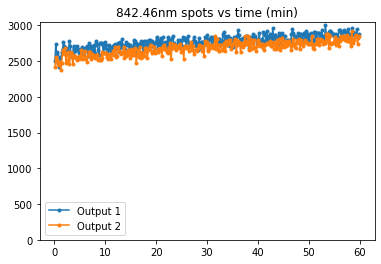

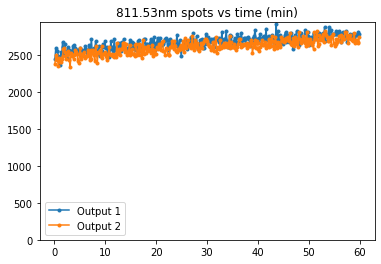

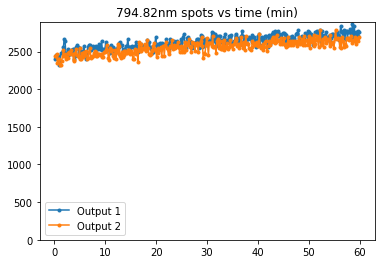

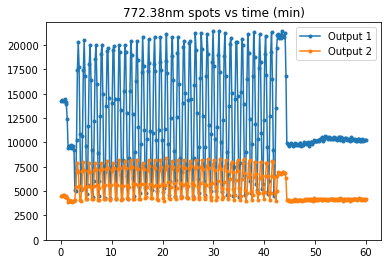

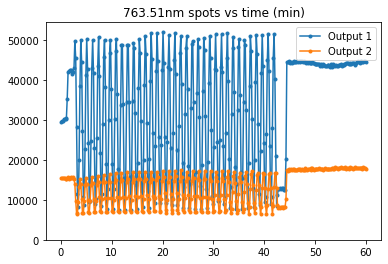

In [382]:
for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]
    
    plt.plot(bin_centers_rt, output_1['hist_vals'], marker='.', label=f"Output {output_1['#output']}")
    plt.plot(bin_centers_rt, output_2['hist_vals'], marker='.', label=f"Output {output_2['#output']}")

    plt.ylim(bottom=0)
    
    plt.title(f"{spot['wavelength(nm)']}nm spots vs time ({time_div_label})")
    plt.legend()
    plt.show()

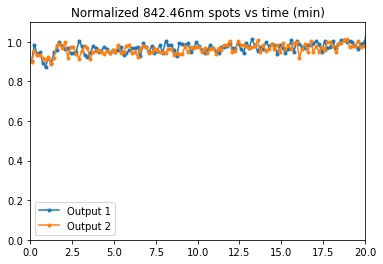

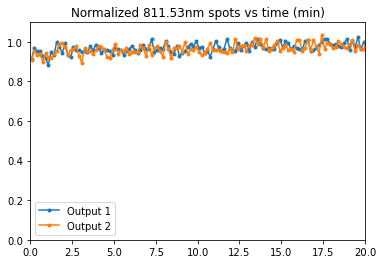

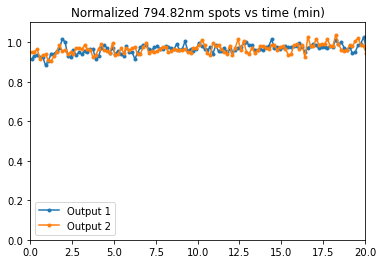

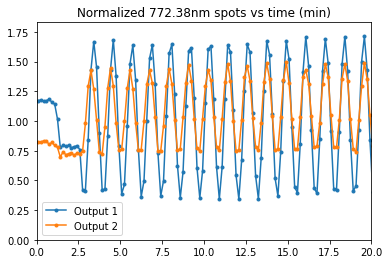

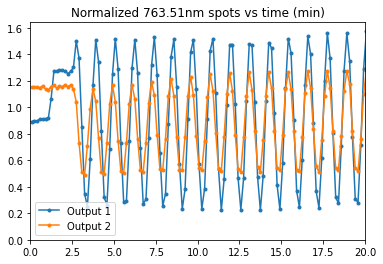

In [383]:
for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]
    
    plt.plot(bin_centers_rt, output_1['hist_vals'] / np.average(output_1['hist_vals']), marker='.', 
             label=f"Output {output_1['#output']}")
    plt.plot(bin_centers_rt, output_2['hist_vals'] / np.average(output_2['hist_vals']), marker='.', 
             label=f"Output {output_2['#output']}")

    plt.ylim(bottom=0)
    plt.xlim(0, 20)
    
    plt.title(f"Normalized {spot['wavelength(nm)']}nm spots vs time ({time_div_label})")
    plt.legend()
    plt.show()

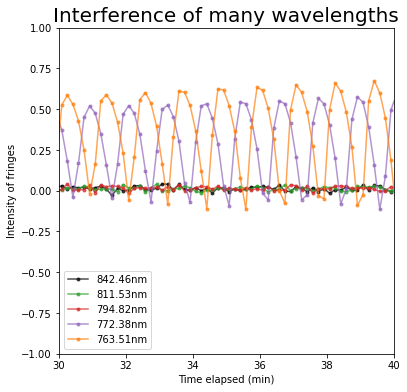

In [406]:
fig, ax = plt.subplots(figsize=(6, 6))
visibility_vals = []

for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]
    
    spot_visibility = (output_1['hist_vals'] - output_2['hist_vals']) / (output_1['hist_vals'] + output_2['hist_vals'])
    visibility_vals.append(spot_visibility)
    visibility_vals.append(-spot_visibility) # Outputs 1 and 2 will get opposite visibility values
    
    plt.plot(bin_centers_rt, spot_visibility, marker='.', color=spot_df.loc[i, 'display_color'], 
             label=f"{spot['wavelength(nm)']}nm", alpha=0.7)

spot_df['vis_vals'] = visibility_vals
    
plt.ylim(-1, 1)
plt.xlim(30, 40)
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel("Intensity of fringes")
plt.title(f"Interference of many wavelengths", fontsize=20)
plt.legend()
plt.show()

# Fourier analysis

## Functions used for finding theoretical interference pattern frequencies

In [385]:
# https://en.wikipedia.org/wiki/Sellmeier_equation
def sellemeier_bk7(wavelength): # Measured in nm
    return np.sqrt(1 + 1.03961212*wavelength**2/(wavelength**2-6.00069867e3) + 0.231792344*wavelength**2/(wavelength**2-2.00179144e4) + 1.01046945*wavelength**2/(wavelength**2-1.03560653e8))

In [386]:
# Only works if motor code is still giving a steps command of value 32 
# (32 steps corresponds to a motor movement of 2.5 microns, scale the 2.5 in the fxn below to the correct value if needed)
# Returns in inverse units of time divisions being used for display units
def find_int_freq(wavelength, motorMovementsPerExposure=motorMovementsPerExposure, exposure_time=exposure_time, time_div_val=time_div_val):
    return(1000*2.5*motorMovementsPerExposure*np.tan(np.radians(1))*(sellemeier_bk7(wavelength)-1) / (wavelength*exposure_time)) * time_div_val

In [387]:
find_int_freq(785, exposure_time = 60, motorMovementsPerExposure=12)

0.34092714607483987

## Defining limits on what gets fourier analyzed

In [388]:
# Times you want the modeling to start and end at (measured in minutes, seconds, etc.)
model_start = 3
model_end = 42

In [389]:
# Finding closest index in bin_centers_rt array to above values
start_index = np.argmin(np.abs(bin_centers_rt-model_start))
end_index = np.argmin(np.abs(bin_centers_rt-model_end))
model_size = end_index - start_index

print(f"The model will start at index {start_index} and end at {end_index} within the value arrays.")

The model will start at index 18 and end at 251 within the value arrays.


In [390]:
# Creating fft values using np.fft.fft
frequencies = np.fft.fftfreq(model_size, bin_centers_rt[1] - bin_centers_rt[0])
fft_vals = []
fft_vis_vals = []

for i, spot in spot_df.iterrows():
    spot_fft = np.fft.fft(spot['hist_vals'][start_index:end_index])
    fft_vals.append(spot_fft)
    
    if i % 2 == 0:
        visibility_fft = np.fft.fft(spot['vis_vals'][start_index:end_index])
        fft_vis_vals.append(visibility_fft)
        fft_vis_vals.append(visibility_fft)
        
spot_df['fft_vals'] = fft_vals
spot_df['fft_vis_vals'] = fft_vis_vals

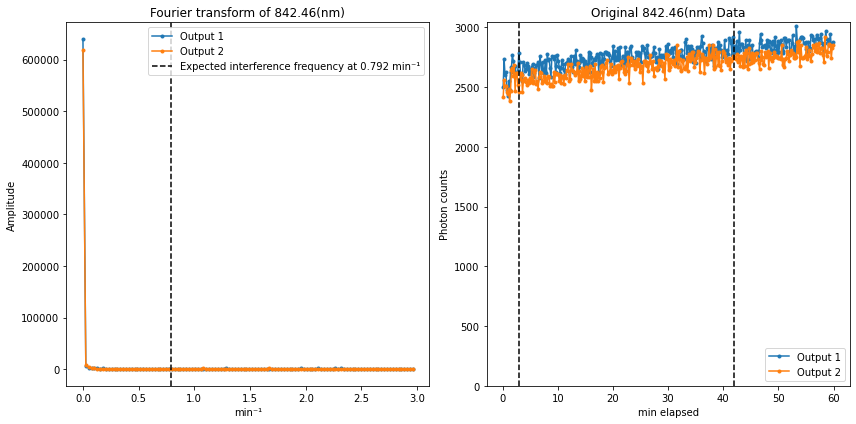

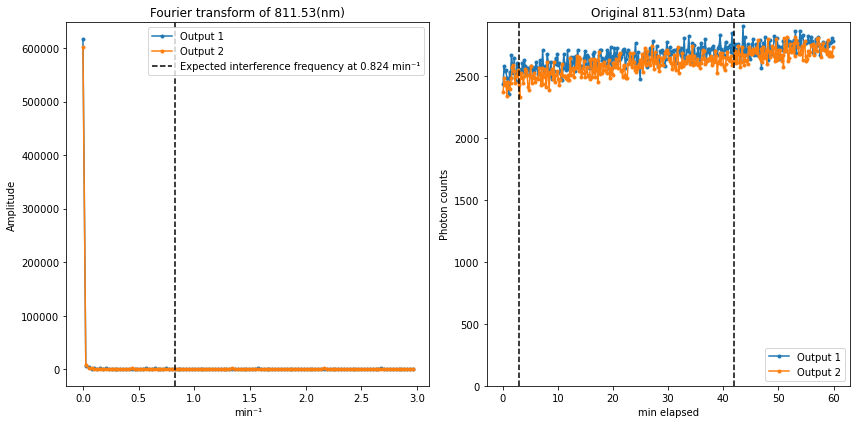

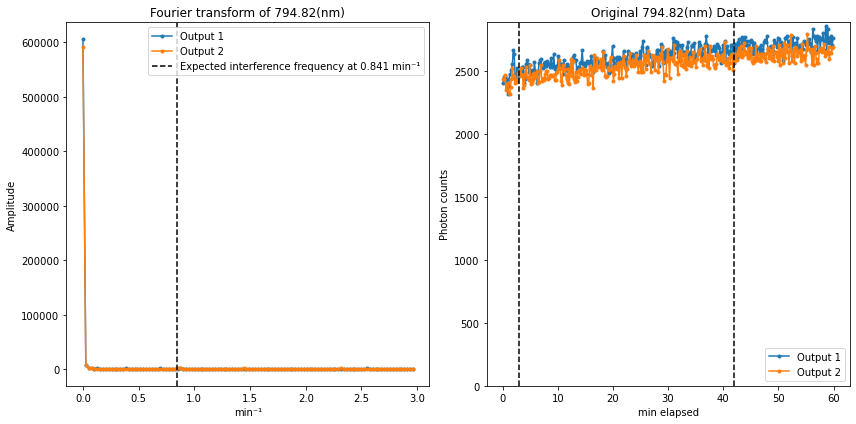

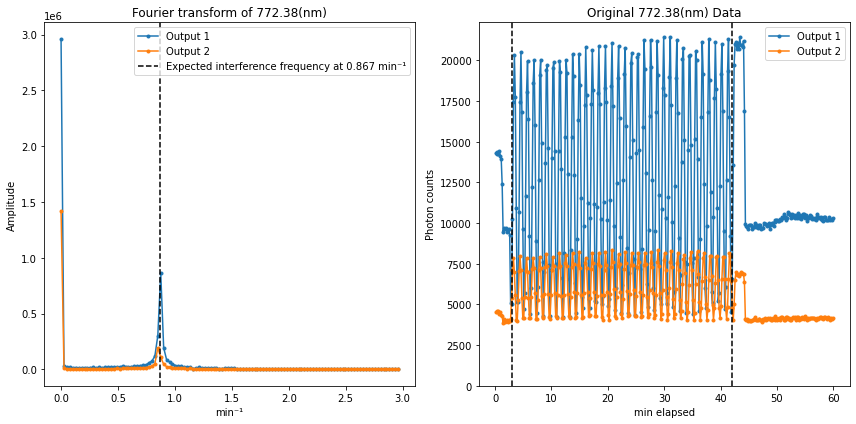

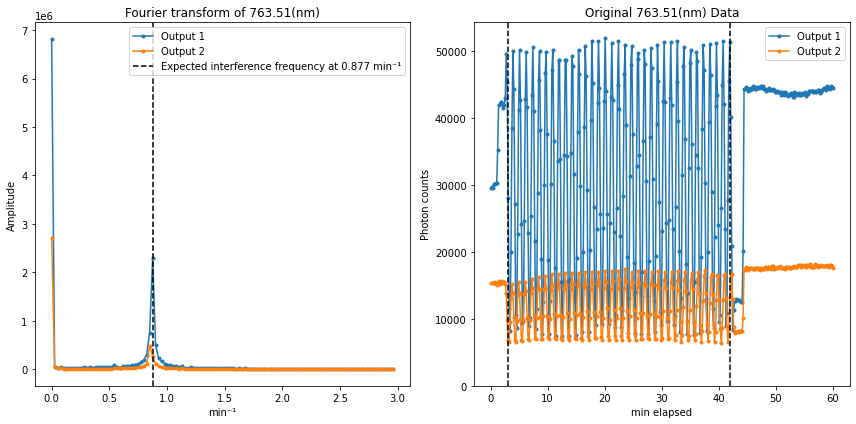

In [391]:
for i, spot in spot_df.iloc[::2].iterrows():
    fft_fig = plt.figure(figsize = (12, 6))
    
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    # Frequency domain
    plt.subplot(121)
    
    # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency (negative values)
    plt.plot(frequencies[:model_size//2], np.abs(output_1['fft_vals'][:model_size//2]), marker='.', label='Output 1')
    plt.plot(frequencies[:model_size//2], np.abs(output_2['fft_vals'][:model_size//2]), marker='.', label='Output 2')

    int_freq = find_int_freq(spot['wavelength(nm)'])
    plt.axvline(x=int_freq, color='Black', ls='--', label=f'Expected interference frequency at {int_freq:.3f} {time_div_label}⁻¹')

    plt.xlabel(f"{time_div_label}⁻¹")
    plt.ylabel("Amplitude")
    plt.title(f"Fourier transform of {output_1['wavelength(nm)']}(nm)")
    plt.legend()

    # Time domain from before being modeled
    plt.subplot(122)
    plt.plot(bin_centers_rt, output_1['hist_vals'], marker='.', label=f"Output {output_1['#output']}")
    plt.plot(bin_centers_rt, output_2['hist_vals'], marker='.', label=f"Output {output_2['#output']}")

    plt.axvline(x=model_start, color='Black', ls='--')
    plt.axvline(x=model_end, color='Black', ls='--')

    plt.ylim(bottom=0)

    plt.title(f"Original {output_1['wavelength(nm)']}(nm) Data")
    plt.xlabel(f"{time_div_label} elapsed")
    plt.ylabel("Photon counts")
    plt.legend()

    fft_fig.tight_layout()
    plt.show()

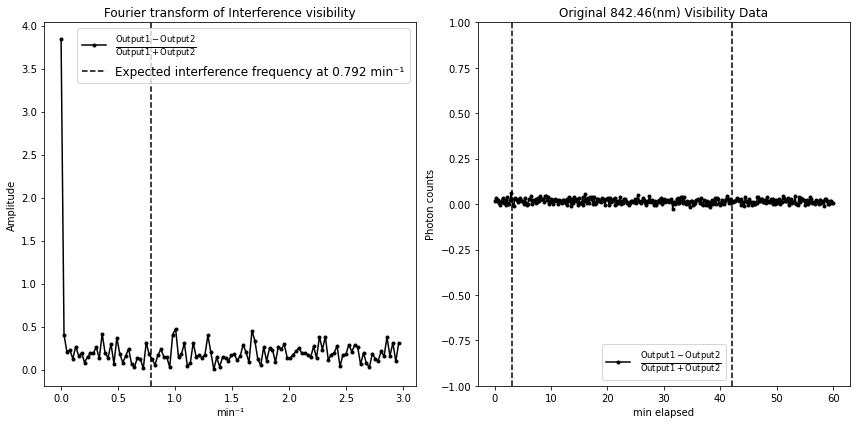

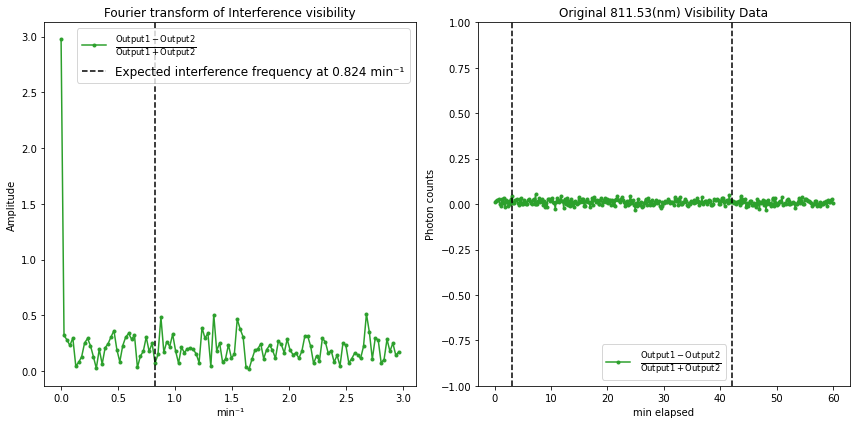

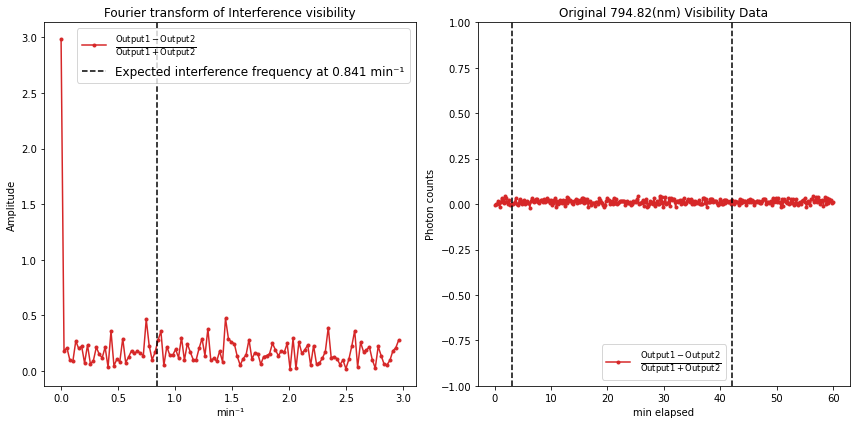

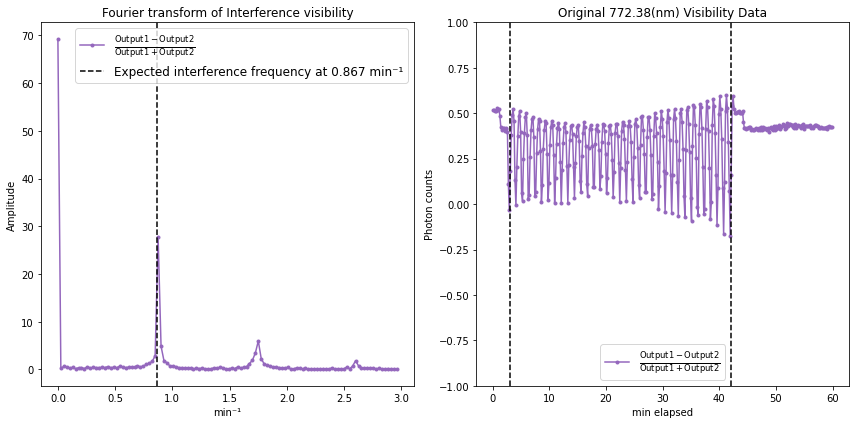

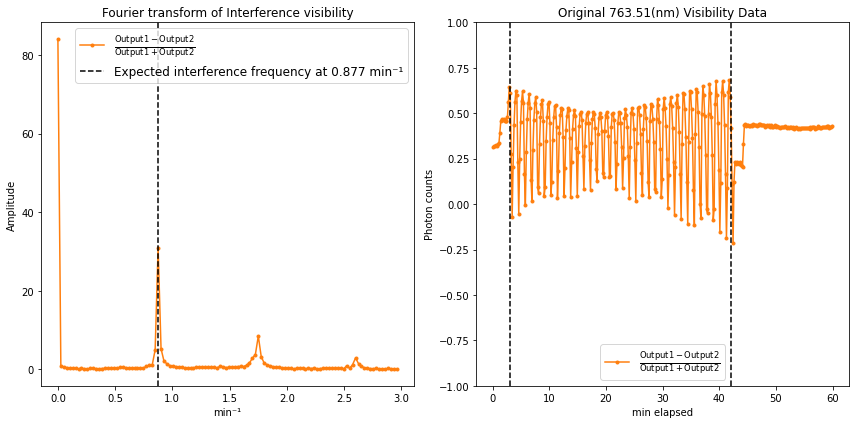

In [392]:
for i, spot in spot_df.iloc[::2].iterrows():
    fft_fig = plt.figure(figsize = (12, 6))

    # Frequency domain
    plt.subplot(121)
    
    # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency (negative values)
    plt.plot(frequencies[:model_size//2], np.abs(spot['fft_vis_vals'][:model_size//2]), marker='.', color=spot['display_color'],
             label=r"$\mathrm{\frac{Output 1 - Output 2}{Output 1 + Output 2}}$")

    int_freq = find_int_freq(spot['wavelength(nm)'])
    plt.axvline(x=int_freq, color='Black', ls='--', label=f'Expected interference frequency at {int_freq:.3f} {time_div_label}⁻¹')

    #plt.ylim(0, 25)
    plt.xlabel(f"{time_div_label}⁻¹")
    plt.ylabel("Amplitude")
    plt.title(f"Fourier transform of Interference visibility")
    plt.legend(fontsize='large')

    # Time domain from before being modeled
    plt.subplot(122)
    plt.plot(bin_centers_rt, spot['vis_vals'], marker='.', color=spot['display_color'], 
             label=r"$\mathrm{\frac{Output 1 - Output 2}{Output 1 + Output 2}}$")

    plt.axvline(x=model_start, color='Black', ls='--')
    plt.axvline(x=model_end, color='Black', ls='--')

    plt.ylim(-1, 1)

    plt.title(f"Original {spot['wavelength(nm)']}(nm) Visibility Data")
    plt.xlabel(f"{time_div_label} elapsed")
    plt.ylabel("Photon counts")
    plt.legend(fontsize='large')

    fft_fig.tight_layout()
    plt.show()